In [1]:

from scipy.stats import norm

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
from pl.bucket_data import get_borough,bucket_by_time
from pl.rush_off_bound import rush_off_bound
from pl.distribution_check import poisson_check,nb_check

In [2]:
DATA_DIR = '202401-citibike-tripdata_2.csv'
DATA_DIR_2  = '202401-citibike-tripdata_1.csv'
data = pl.read_csv(DATA_DIR,ignore_errors=True)
data2 = pl.read_csv(DATA_DIR_2,ignore_errors=True)
data = data.vstack(data2)
print(data.sort('started_at'))

shape: (1_888_085, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ ride_id   ┆ rideable_ ┆ started_a ┆ ended_at  ┆ … ┆ start_lng ┆ end_lat   ┆ end_lng   ┆ member_c │
│ ---       ┆ type      ┆ t         ┆ ---       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ asual    │
│ str       ┆ ---       ┆ ---       ┆ str       ┆   ┆ f64       ┆ f64       ┆ f64       ┆ ---      │
│           ┆ str       ┆ str       ┆           ┆   ┆           ┆           ┆           ┆ str      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 5594D8DDA ┆ classic_b ┆ 2023-12-3 ┆ 2024-01-0 ┆ … ┆ -73.98765 ┆ null      ┆ null      ┆ casual   │
│ 68F5BB9   ┆ ike       ┆ 1 02:36:5 ┆ 1 03:36:4 ┆   ┆ 4         ┆           ┆           ┆          │
│           ┆           ┆ 5.648     ┆ 8.341     ┆   ┆           ┆           ┆           ┆          │
│ 36D094894 ┆ classic_b ┆ 2023-12-3 ┆ 2024-01-0 ┆ … ┆ -73.98770 ┆ nu

In [3]:
data = data.with_columns(
    pl.col("started_at").str.to_datetime(strict=False),
    pl.col("ended_at").str.to_datetime(strict=False)
)
data = data.with_columns(
    pl.col("started_at").dt.date().alias("start_date"),
    pl.col("started_at").dt.time().alias("start_time"),
    pl.col("ended_at").dt.date().alias("end_date"),
    pl.col("ended_at").dt.time().alias("end_time"),
)
data = data.with_columns(
    (pl.col("ended_at")- pl.col("started_at")).alias("trip_time")
)
data = data.with_columns(
    pl.struct(['start_lat', 'start_lng'])
    .map_elements(
        lambda x: get_borough(x['start_lat'], x['start_lng']),
        return_dtype=pl.Utf8
    )
    .alias('start_borough')
)
data = data.with_columns(
    pl.struct(['end_lat', 'end_lng'])
    .map_elements(
        lambda x: get_borough(x['end_lat'], x['end_lng']),
        return_dtype=pl.Utf8
    )
    .alias('end_borough')
)


counts = data['end_borough'].value_counts()
print(counts)
print(data.head(0))


shape: (4, 2)
┌─────────────┬─────────┐
│ end_borough ┆ count   │
│ ---         ┆ ---     │
│ str         ┆ u32     │
╞═════════════╪═════════╡
│ Manhattan   ┆ 1500095 │
│ Unknown     ┆ 5578    │
│ Brooklyn    ┆ 323024  │
│ Bronx       ┆ 59388   │
└─────────────┴─────────┘
shape: (0, 20)
┌─────────┬────────────┬────────────┬───────────┬───┬──────────┬───────────┬───────────┬───────────┐
│ ride_id ┆ rideable_t ┆ started_at ┆ ended_at  ┆ … ┆ end_time ┆ trip_time ┆ start_bor ┆ end_borou │
│ ---     ┆ ype        ┆ ---        ┆ ---       ┆   ┆ ---      ┆ ---       ┆ ough      ┆ gh        │
│ str     ┆ ---        ┆ datetime[μ ┆ datetime[ ┆   ┆ time     ┆ duration[ ┆ ---       ┆ ---       │
│         ┆ str        ┆ s]         ┆ μs]       ┆   ┆          ┆ μs]       ┆ str       ┆ str       │
╞═════════╪════════════╪════════════╪═══════════╪═══╪══════════╪═══════════╪═══════════╪═══════════╡
└─────────┴────────────┴────────────┴───────────┴───┴──────────┴───────────┴───────────┴───────────┘


# Rush hour(Top30)
# Arrivals and Departures
### Data aggregated over boroughs

In [4]:
manhattan_data_a = data.filter(
    pl.col('end_borough') == 'Manhattan'
)
manhattan_data_d = data.filter(
    pl.col('start_borough') == 'Manhattan'
)

In [5]:
counts_ss = manhattan_data_d['start_station_name'].value_counts()
print(counts_ss)
counts_es = manhattan_data_a['end_station_name'].value_counts()
print(counts_es)
counts_sb = manhattan_data_d['start_borough'].value_counts()
print(counts_sb)
counts_eb = manhattan_data_a['end_borough'].value_counts()
print(counts_eb)

shape: (1_099, 2)
┌─────────────────────────────────┬───────┐
│ start_station_name              ┆ count │
│ ---                             ┆ ---   │
│ str                             ┆ u32   │
╞═════════════════════════════════╪═══════╡
│ Lincoln Ave & E 134 St          ┆ 249   │
│ E 14 St & Ave B                 ┆ 2636  │
│ 9 Ave & W 45 St                 ┆ 3399  │
│ W 56 St & 10 Ave                ┆ 2727  │
│ Jerome Ave & W 177 St           ┆ 58    │
│ …                               ┆ …     │
│ W 4 St & 7 Ave S                ┆ 3458  │
│ Adam Clayton Powell Blvd & W 1… ┆ 828   │
│ W 15 St & 10 Ave                ┆ 1326  │
│ Washington Pl & 6 Ave           ┆ 2180  │
│ E 27 St & 1 Ave                 ┆ 3720  │
└─────────────────────────────────┴───────┘
shape: (1_101, 2)
┌────────────────────────────┬───────┐
│ end_station_name           ┆ count │
│ ---                        ┆ ---   │
│ str                        ┆ u32   │
╞════════════════════════════╪═══════╡
│ Columbus Ave & W 10

In [6]:
manhattan_1h_a = bucket_by_time(manhattan_data_a, group_col=['end_station_name'], condition='arrival', freq='1h')
manhattan_1h_d = bucket_by_time(manhattan_data_d, group_col=['start_station_name'], condition='departure', freq='1h')
print(manhattan_1h_a)
print(manhattan_1h_d)

shape: (744, 1_102)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ event_tim ┆ 21 St &   ┆ Brook Ave ┆ Nassau    ┆ … ┆ Page Pl & ┆ Sedgwick  ┆ 190       ┆ Pillar   │
│ e_bucket  ┆ 43 Ave    ┆ & E 138   ┆ Ave &     ┆   ┆ Grand Ave ┆ Ave &     ┆ Morgan    ┆ Broadway │
│ ---       ┆ ---       ┆ St        ┆ Russell   ┆   ┆ ---       ┆ Hall of   ┆ ---       ┆ & W 25   │
│ datetime[ ┆ u32       ┆ ---       ┆ St        ┆   ┆ u32       ┆ Fame Te…  ┆ u32       ┆ St       │
│ μs]       ┆           ┆ u32       ┆ ---       ┆   ┆           ┆ ---       ┆           ┆ ---      │
│           ┆           ┆           ┆ u32       ┆   ┆           ┆ u32       ┆           ┆ u32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 2024-01-1 ┆ 1         ┆ 0         ┆ 0         ┆ … ┆ 1         ┆ 0         ┆ 0         ┆ 0        │
│ 4         ┆           ┆           ┆           ┆   ┆           ┆      

shape: (24, 2)
┌──────┬───────────┐
│ hour ┆ total_sum │
│ ---  ┆ ---       │
│ i8   ┆ u32       │
╞══════╪═══════════╡
│ 13   ┆ 84569     │
│ 2    ┆ 6951      │
│ 11   ┆ 71850     │
│ 16   ┆ 111258    │
│ 3    ┆ 4597      │
│ …    ┆ …         │
│ 10   ┆ 72275     │
│ 17   ┆ 132351    │
│ 23   ┆ 25122     │
│ 12   ┆ 80383     │
│ 20   ┆ 63479     │
└──────┴───────────┘
{'total_sum': [16, 18, 8, 9, 14, 15, 17]}
shape: (217, 5)
┌─────────────────────┬───────────┬────────────┬──────────┬──────┐
│ event_time_bucket   ┆ total_sum ┆ date       ┆ time     ┆ hour │
│ ---                 ┆ ---       ┆ ---        ┆ ---      ┆ ---  │
│ datetime[μs]        ┆ u32       ┆ date       ┆ time     ┆ i8   │
╞═════════════════════╪═══════════╪════════════╪══════════╪══════╡
│ 2024-01-23 08:00:00 ┆ 5869      ┆ 2024-01-23 ┆ 08:00:00 ┆ 8    │
│ 2024-01-07 08:00:00 ┆ 566       ┆ 2024-01-07 ┆ 08:00:00 ┆ 8    │
│ 2024-01-26 08:00:00 ┆ 3045      ┆ 2024-01-26 ┆ 08:00:00 ┆ 8    │
│ 2024-01-02 08:00:00 ┆ 4172      

/var/folders/s4/k2c6nj9n4371mjry_0bbj6180000gn/T/ipykernel_10101/3662520605.py:7: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivoted_manhattan_a = manhattan_sum_reordered_a.pivot(


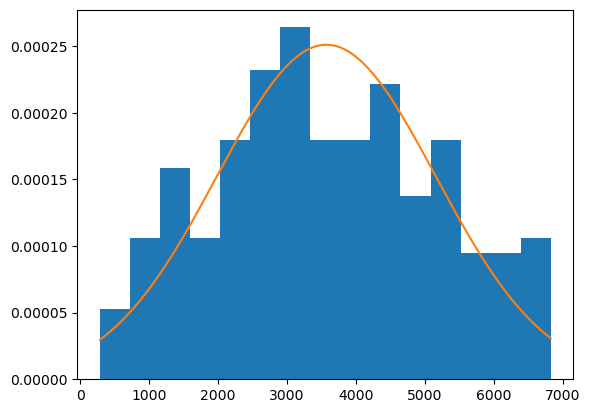

In [7]:
# arrivals
manhattan_sum_1h_a = manhattan_1h_a.select(pl.col('event_time_bucket'),
                                   pl.sum_horizontal(pl.all().exclude('event_time_bucket')).alias('total_sum'))
manhattan_sum_reordered_a = manhattan_sum_1h_a.with_columns(pl.col('event_time_bucket').dt.date().alias('date'),
                                              pl.col('event_time_bucket').dt.time().alias('time'),)
columns = ['date']
pivoted_manhattan_a = manhattan_sum_reordered_a.pivot(
    values='total_sum',
    columns = columns,
    aggregate_function='sum',
    index = 'time'
)
pivoted_manhattan_sum_a = pivoted_manhattan_a.select(pl.col('time').alias('event_time_bucket'),
                                     pl.sum_horizontal(pl.all().exclude('time').alias('total_sum')))
peak_hours_a_mh = rush_off_bound(pivoted_manhattan_sum_a,
                            threshold = 0.70,
                            condition= 'hour',
                            check_var = 'rush',
                            bound = 'markov',
                            dist_var = 'none')
print(peak_hours_a_mh)
manhattan_sum_reordered_a = manhattan_sum_reordered_a.with_columns(pl.col('event_time_bucket').dt.hour().alias('hour'))
manhattan_top30_a = manhattan_sum_reordered_a.filter(pl.col('hour')
                                                     .is_in(peak_hours_a_mh['total_sum'])).sort('hour')

print(manhattan_top30_a)
print(manhattan_top30_a['total_sum'].to_list())
data_l3_a = np.array(manhattan_top30_a['total_sum'].to_list())
data_l3_mean_a = np.mean(data_l3_a)
data_l3_std_a = np.std(data_l3_a)
print(data_l3_mean_a)
print(data_l3_std_a**2)

plt.hist(data_l3_a, bins=15, density=True)
xs_a = np.linspace(min(data_l3_a), max(data_l3_a), 200)
plt.plot(xs_a, norm.pdf(xs_a, loc=data_l3_mean_a, scale=data_l3_std_a))

Final Bin values: 42


/Users/nitinshreyes/PycharmProjects/PythonProject2/202401-citibike-tripdata/distribution_check.py:14: RuntimeWarning: overflow encountered in scalar divide
  dummy = ((observed[i] - expected[i])**2 / expected[i])


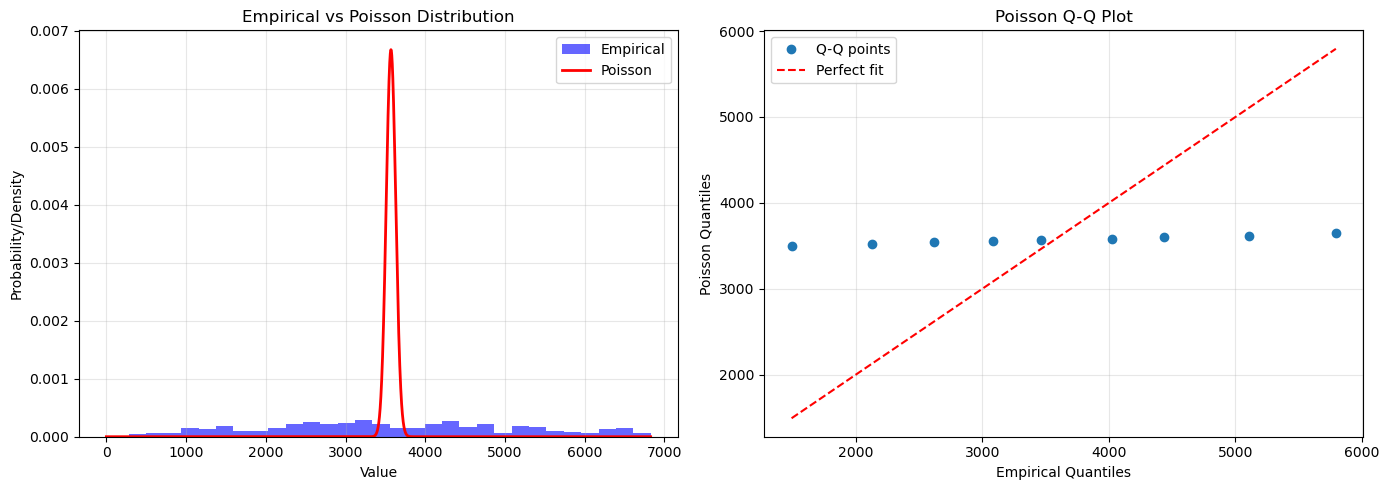

{'chi_score': np.float64(inf), 'dispersion': np.float64(710.9605082163441), 'emp_quantile': array([1493. , 2126.8, 2618.2, 3081.8, 3467. , 4021. , 4434.2, 5109.8,
       5793. ]), 'poisson_quantile': [np.float64(3494.0), np.float64(3520.0), np.float64(3539.0), np.float64(3555.0), np.float64(3570.0), np.float64(3585.0), np.float64(3601.0), np.float64(3620.0), np.float64(3647.0)], 'p_value': np.float64(0.0)}


In [8]:
poi_dict_mh_a = poisson_check(data_l3_a)
print(poi_dict_mh_a)

Final Bin values (NB): 42


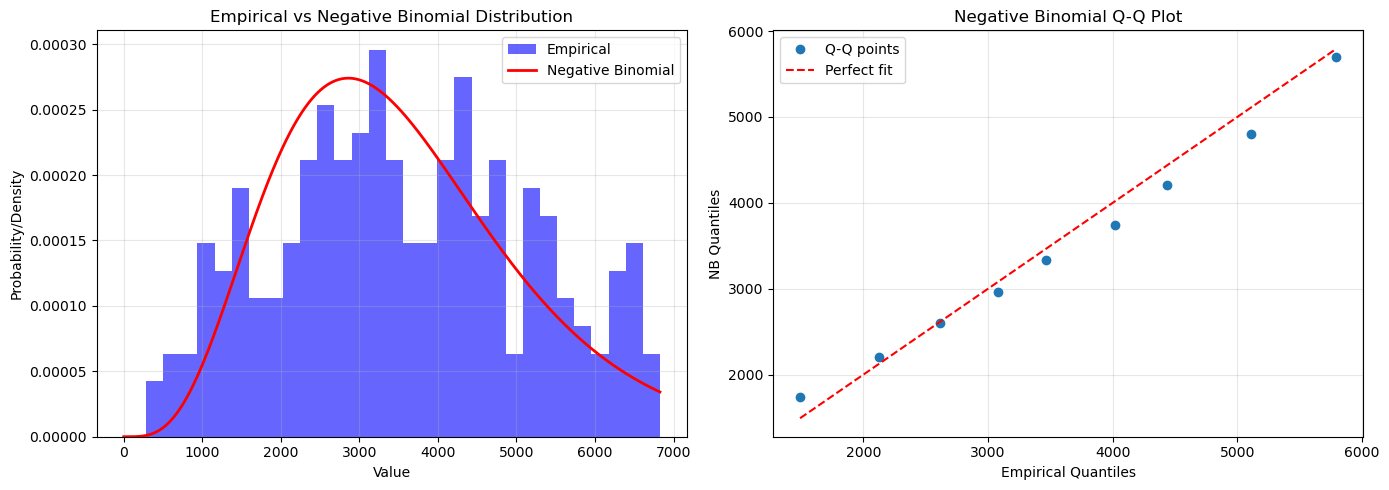

{'chi_score': np.float64(84.26411607619536), 'dispersion': np.float64(710.9605082163441), 'emp_quantile': array([1493. , 2126.8, 2618.2, 3081.8, 3467. , 4021. , 4434.2, 5109.8,
       5793. ]), 'nb_quantile': [np.float64(1740.0), np.float64(2209.0), np.float64(2597.0), np.float64(2963.0), np.float64(3336.0), np.float64(3739.0), np.float64(4205.0), np.float64(4797.0), np.float64(5703.0)], 'n_param': np.float64(5.028617471466864), 'p_param': np.float64(0.0014065478861952506), 'p_value': np.float64(3.575808308029912e-05)}


In [9]:
nb_dict_mh_a = nb_check(data_l3_a)
print(nb_dict_mh_a)

shape: (24, 2)
┌──────┬───────────┐
│ hour ┆ total_sum │
│ ---  ┆ ---       │
│ i8   ┆ u32       │
╞══════╪═══════════╡
│ 8    ┆ 113803    │
│ 21   ┆ 46397     │
│ 18   ┆ 122295    │
│ 0    ┆ 16034     │
│ 22   ┆ 35120     │
│ …    ┆ …         │
│ 16   ┆ 114605    │
│ 6    ┆ 36045     │
│ 23   ┆ 24642     │
│ 15   ┆ 103913    │
│ 2    ┆ 6781      │
└──────┴───────────┘
{'total_sum': [8, 18, 17, 9, 14, 16, 15]}
shape: (223, 5)
┌─────────────────────┬───────────┬────────────┬──────────┬──────┐
│ event_time_bucket   ┆ total_sum ┆ date       ┆ time     ┆ hour │
│ ---                 ┆ ---       ┆ ---        ┆ ---      ┆ ---  │
│ datetime[μs]        ┆ u32       ┆ date       ┆ time     ┆ i8   │
╞═════════════════════╪═══════════╪════════════╪══════════╪══════╡
│ 2024-01-29 08:00:00 ┆ 4912      ┆ 2024-01-29 ┆ 08:00:00 ┆ 8    │
│ 2024-01-12 08:00:00 ┆ 5177      ┆ 2024-01-12 ┆ 08:00:00 ┆ 8    │
│ 2024-01-08 08:00:00 ┆ 5423      ┆ 2024-01-08 ┆ 08:00:00 ┆ 8    │
│ 2024-01-30 08:00:00 ┆ 6616      

/var/folders/s4/k2c6nj9n4371mjry_0bbj6180000gn/T/ipykernel_10101/1647170288.py:7: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  pivoted_manhattan_d = manhattan_sum_reordered_d.pivot(


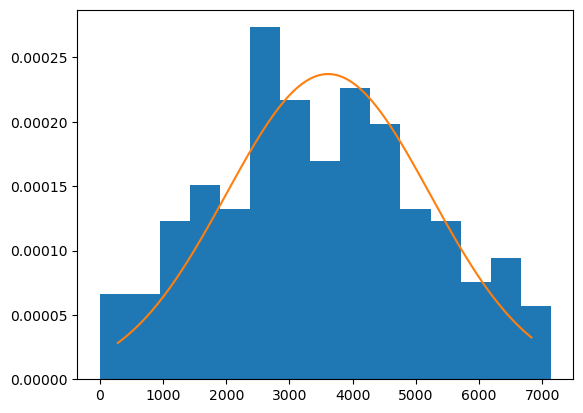

In [10]:
# departures
manhattan_sum_1h_d = manhattan_1h_d.select(pl.col('event_time_bucket'),
                                   pl.sum_horizontal(pl.all().exclude('event_time_bucket')).alias('total_sum'))
manhattan_sum_reordered_d = manhattan_sum_1h_d.with_columns(pl.col('event_time_bucket').dt.date().alias('date'),
                                              pl.col('event_time_bucket').dt.time().alias('time'),)
columns = ['date']
pivoted_manhattan_d = manhattan_sum_reordered_d.pivot(
    values='total_sum',
    columns = columns,
    aggregate_function='sum',
    index = 'time'
)
pivoted_manhattan_sum_d = pivoted_manhattan_d.select(pl.col('time').alias('event_time_bucket'),
                                     pl.sum_horizontal(pl.all().exclude('time').alias('total_sum')))
peak_hours_d_mh = rush_off_bound(pivoted_manhattan_sum_d,
                            threshold = 0.70,
                            condition= 'hour',
                            check_var = 'rush',
                            bound = 'markov',
                            dist_var = 'none')
print(peak_hours_d_mh)
manhattan_sum_reordered_d = manhattan_sum_reordered_d.with_columns(pl.col('event_time_bucket').dt.hour().alias('hour'))
manhattan_top30_d = manhattan_sum_reordered_d.filter(pl.col('hour')
                                                     .is_in(peak_hours_d_mh['total_sum'])).sort('hour')

print(manhattan_top30_d)
print(manhattan_top30_d['total_sum'].to_list())
data_l3_d = np.array(manhattan_top30_d['total_sum'].to_list())
data_l3_mean_d = np.mean(data_l3_d)
data_l3_std_d = np.std(data_l3_d)
print(data_l3_mean_d)
print(data_l3_std_d**2)

plt.hist(data_l3_d, bins=15, density=True)
xs_d = np.linspace(min(data_l3_d), max(data_l3_a), 200)
plt.plot(xs_a, norm.pdf(xs_d, loc=data_l3_mean_d, scale=data_l3_std_d))

Final Bin values: 44


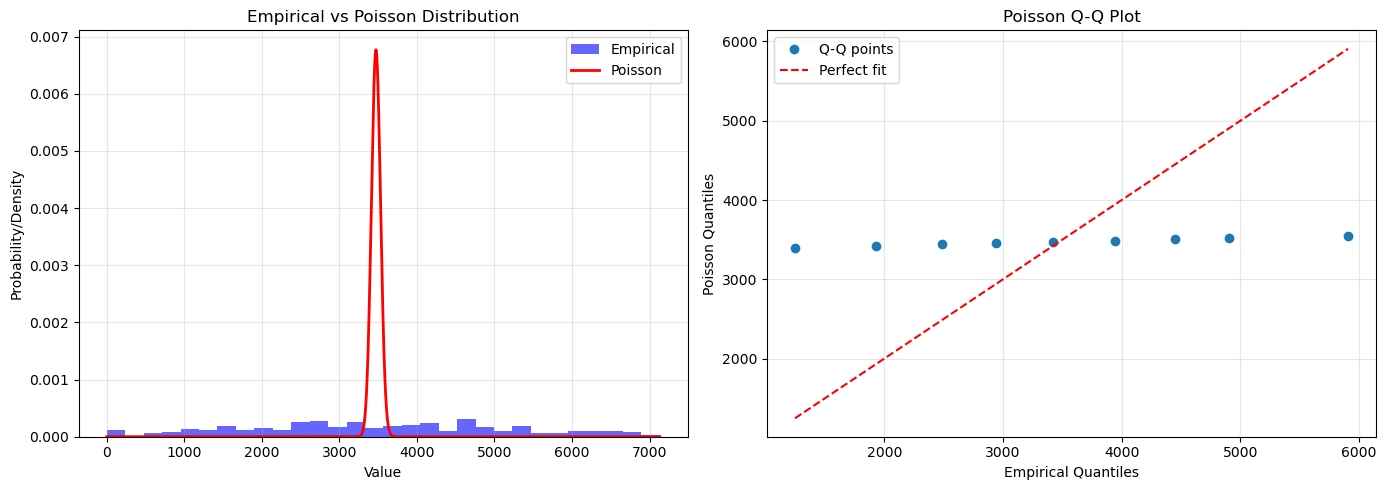

{'chi_score': np.float64(1.6982180774799078e+291), 'dispersion': np.float64(818.7523213817343), 'emp_quantile': array([1248. , 1926.8, 2482.4, 2944.2, 3421. , 3942.8, 4448.2, 4903.6,
       5907. ]), 'poisson_quantile': [np.float64(3397.0), np.float64(3423.0), np.float64(3441.0), np.float64(3457.0), np.float64(3472.0), np.float64(3487.0), np.float64(3503.0), np.float64(3522.0), np.float64(3548.0)], 'p_value': np.float64(0.0)}


In [11]:
poi_dict_mh_d = poisson_check(data_l3_d)
print(poi_dict_mh_d)

Final Bin values (NB): 44


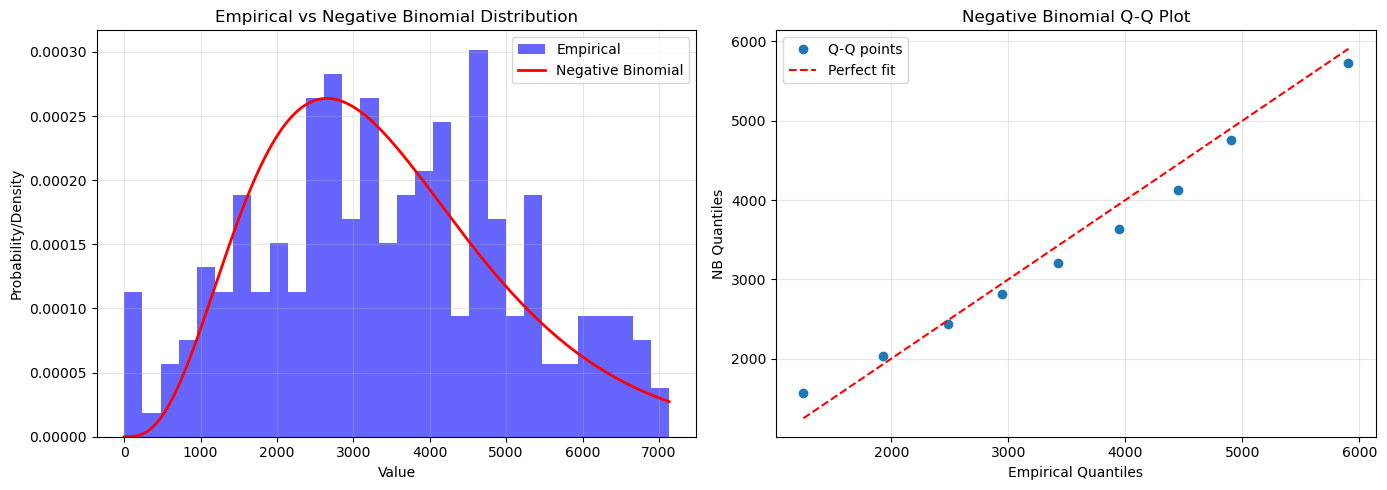

{'chi_score': np.float64(6075.964023876622), 'dispersion': np.float64(818.7523213817343), 'emp_quantile': array([1248. , 1926.8, 2482.4, 2944.2, 3421. , 3942.8, 4448.2, 4903.6,
       5907. ]), 'nb_quantile': [np.float64(1561.0), np.float64(2035.0), np.float64(2433.0), np.float64(2813.0), np.float64(3204.0), np.float64(3629.0), np.float64(4123.0), np.float64(4755.0), np.float64(5732.0)], 'n_param': np.float64(4.246031106160709), 'p_param': np.float64(0.0012213705828795578), 'p_value': np.float64(0.0)}


In [12]:
nb_dict_mh_d = nb_check(data_l3_d)
print(nb_dict_mh_d)